In [1]:
CODE_PATH = '../../code/'
MNIST_DATA_PATH = '../../data/morphomnist/'
BASE_LOG_PATH = '../../models/morphomnist/SVIExperiment'

# Setup

In [2]:
%matplotlib inline
import sys
import os

sys.path.append(CODE_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

import traceback
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'

In [4]:
from datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(MNIST_DATA_PATH, train=False, columns=['thickness', 'intensity'])

In [5]:
from datasets.morphomnist.create_synth_thickness_intensity_data import model as true_model
from experiments import morphomnist
from experiments.morphomnist.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [6]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

In [7]:
from morphomnist import measure
import multiprocessing

def measure_image(x, threshold=0.5, use_progress_bar=True):
    imgs = x.detach().cpu().numpy()[:, 0]

    with multiprocessing.Pool() as pool:
        measurements = measure.measure_batch(imgs, threshold=threshold, use_progress_bar=use_progress_bar, pool=pool)

    def get_intensity(imgs, threshold):

        img_min, img_max = imgs.min(axis=(1, 2), keepdims=True), imgs.max(axis=(1, 2), keepdims=True)
        mask = (imgs >= img_min + (img_max - img_min) * threshold)

        return np.array([np.median(i[m]) for i, m in zip(imgs, mask)])

    return measurements['thickness'].values, get_intensity(imgs, threshold)

In [8]:
experiments = ['IndependentVISEM', 'ConditionalDecoderVISEM', 'ConditionalVISEM']

models = {'true': true_model,}

loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_0/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hparams']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

In [9]:
var_name = {'thickness': 't', 'intensity': 'i'}
value_fmt = {
    'thickness': lambda s: rf"{float(s):.1f}",
    'intensity': lambda s: rf"{int(s):d}"
}

def fmt_intervention(intervention):
    all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
    return f"$do({all_interventions})$"

def plot_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32):
    fig, ax = plt.subplots(3, len(interventions), figsize=(1.6 * len(interventions), 5), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0
    
    orig_data = prep_data(test_data[idx])
    
    imgs = []
    for intervention in interventions:
        cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
        counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

        imgs += [counterfactual['x']]
        
        diff = (orig_data['x'] - imgs[-1]).squeeze()

        lim = np.maximum(lim, diff.abs().max())

    for i, intervention in enumerate(interventions):
        x = imgs[i]
        x_test = orig_data['x']
        diff = (x_test - x).squeeze()
        if not normalise_all:
            lim = diff.abs().max()

        ax[0, i].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        
        ax[0, i].set_title(fmt_intervention(intervention))
        ax[1, i].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

        ax[2, i].imshow(diff, 'seismic', clim=[-lim, lim])

        for axi in ax[:, i]:
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())
    
    suptitle = '$t={thickness}; i={intensity}$'.format(
        **{att: value_fmt[att](orig_data[att].item()) for att in ('thickness', 'intensity')}
    )
    fig.suptitle(suptitle, fontsize=14, y=1.02)
    
    fig.tight_layout()
    plt.show()

# Plotting

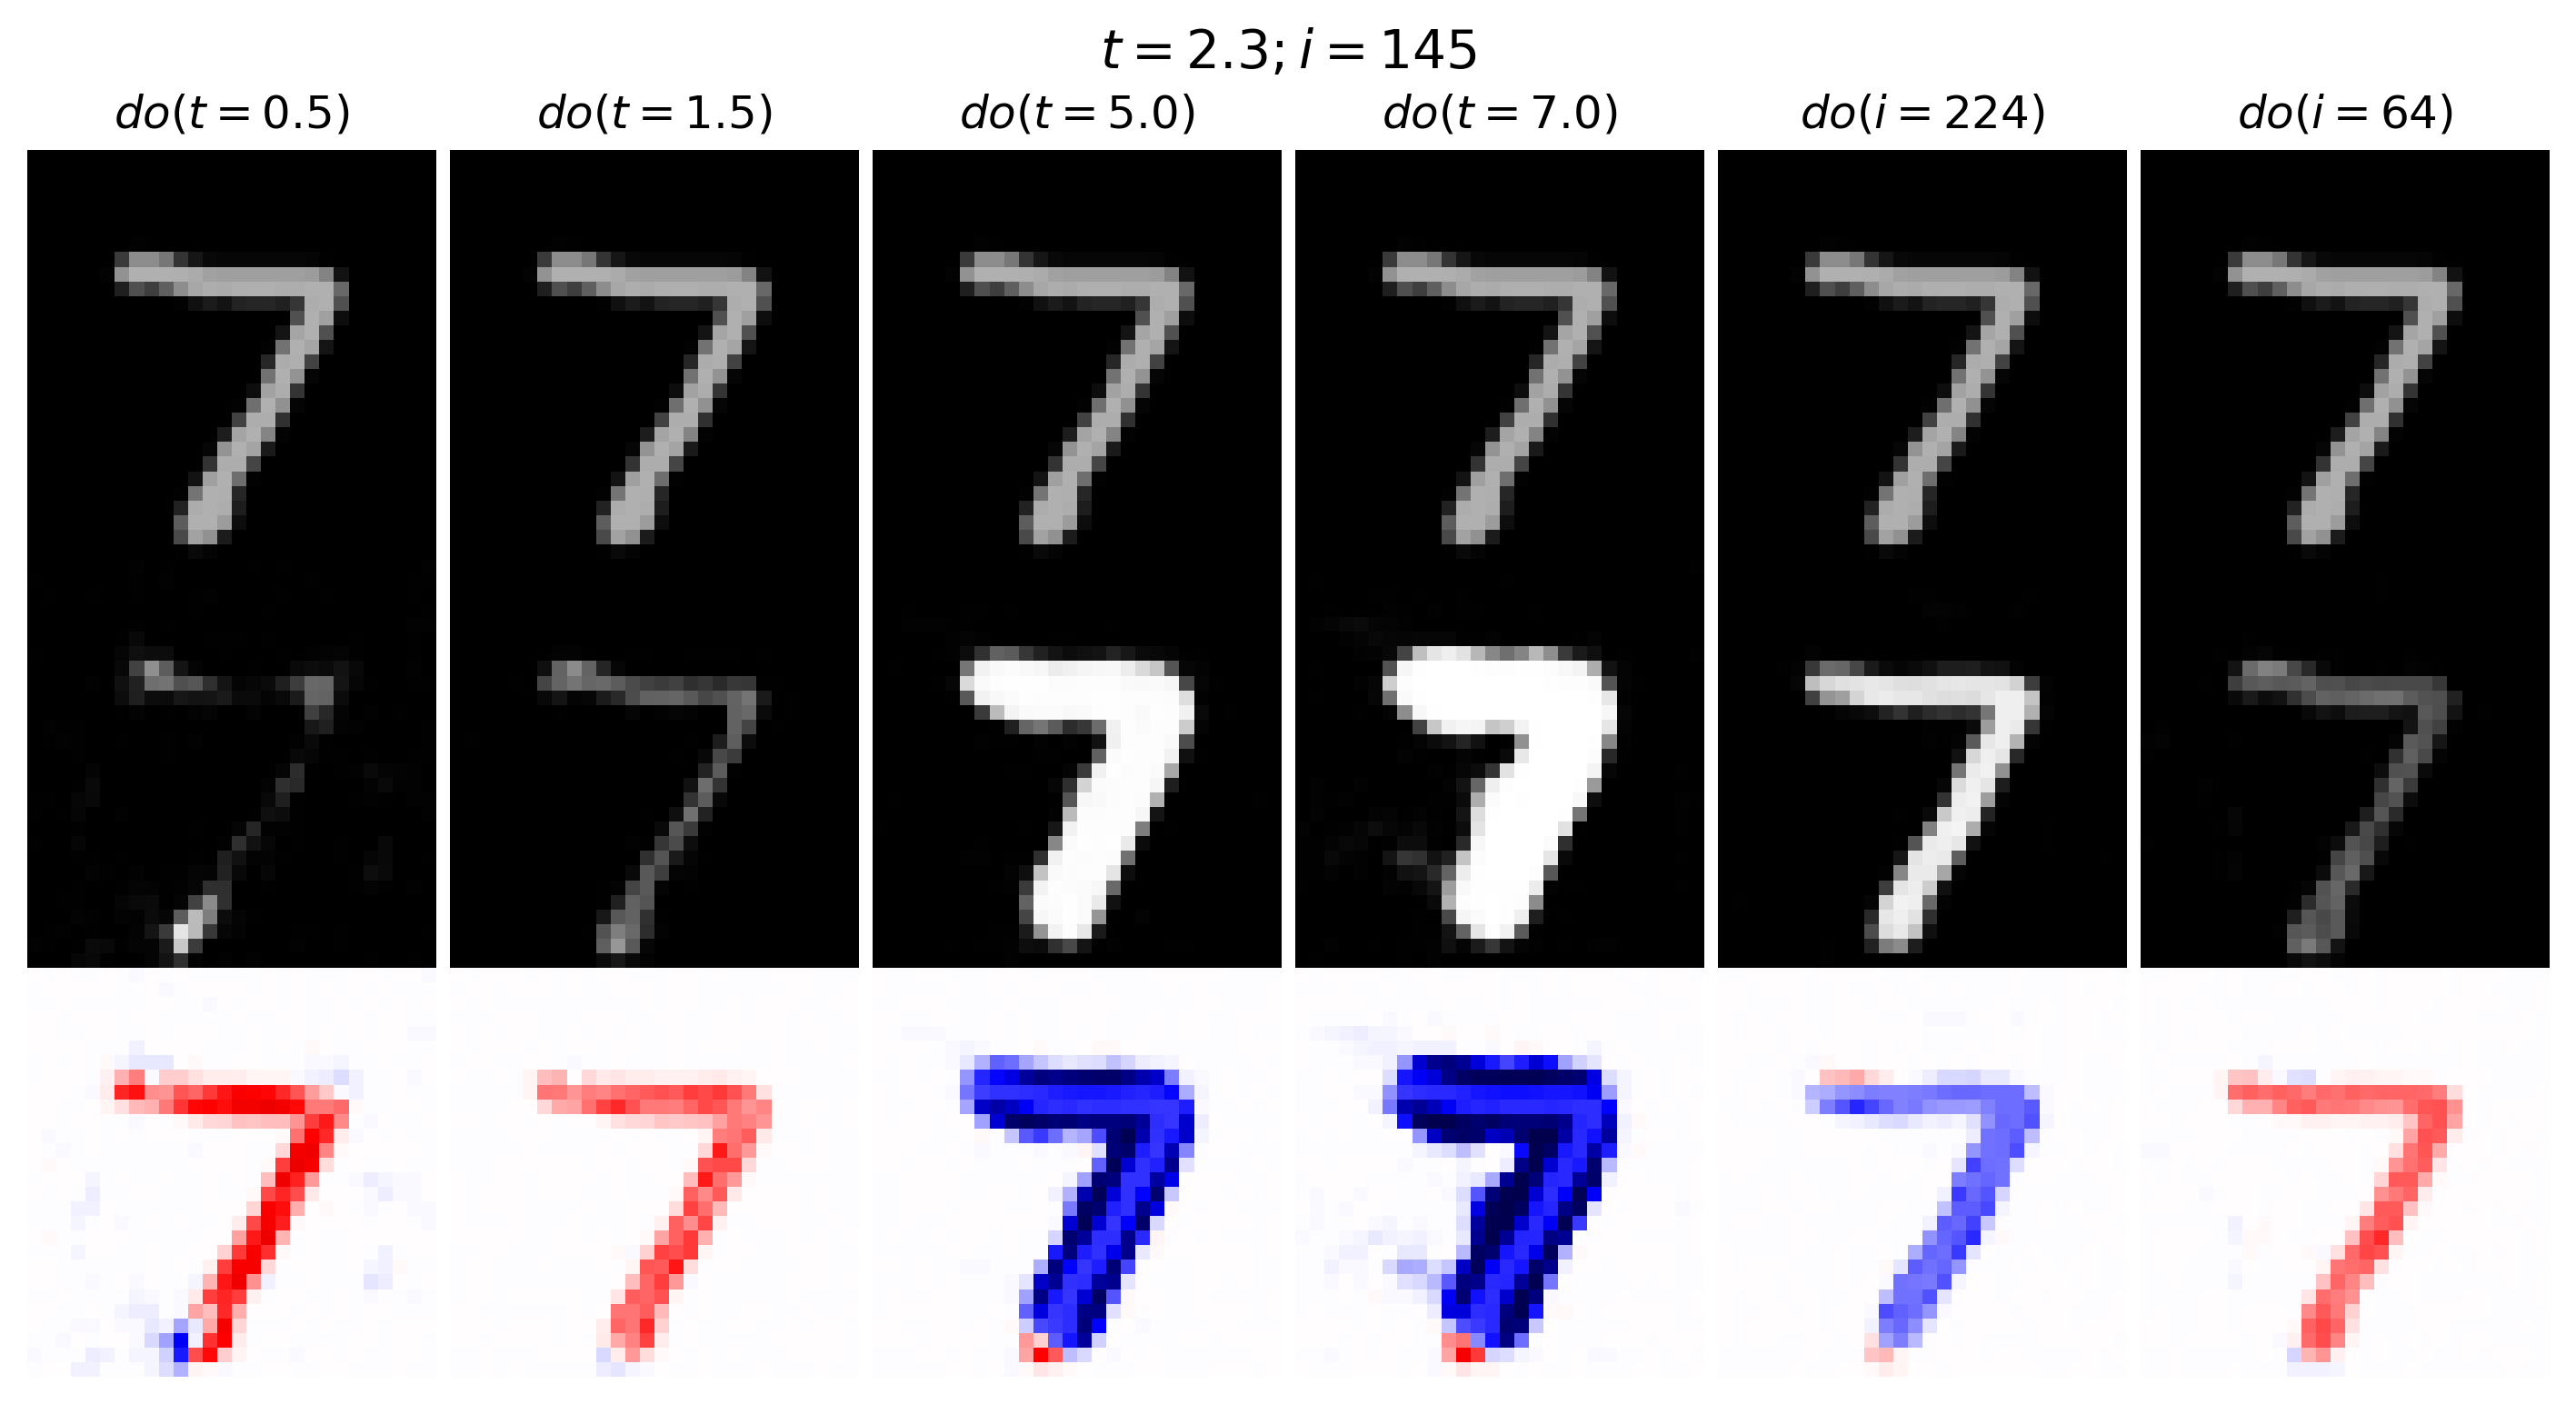

In [10]:
idx = 0
model_name = 'ConditionalVISEM'

orig_data = prep_data(test_data[idx])

interventions = [
    {'thickness': 0.5},
    {'thickness': 1.5},
    {'thickness': 5.},
    {'thickness': 7.},
    {'intensity': 224.},
    {'intensity': 64.}
]

plot_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32)

